(example_3)=
# Example 3: A multi-armed bandit task with independent reward and punishments

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install pyhgf

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from scipy.stats import norm
import jax.numpy as jnp

from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF

In this notebook, we are going to illustrate how to fit behavioural responses from a two-armed bandit task when the rewards and punishments are independent. The task is similar to what was used in {cite:p}`Pulcu2017`. This will also illustrate how to use missing observations and the impact it has on the belief trajectories.

Because the rewards and punishments are independent, we simulate the task using four binary HGFs, assuming that on both arms, both rewards and punishments are evolving independently, and how to deal with models where the decisions of the agent influence the observations.

```{note}
While the binary HGF is a special case of the categorical HGF where the number of categories is set to 2, the categorical HGF adds a volatility coupling between the binary branch (see {ref}`categorical_hgf`). Therefore a categorical HGF would not be suitable here as we want every branch of the network to evolve independently.
```

I0000 00:00:1700647549.454170   17702 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


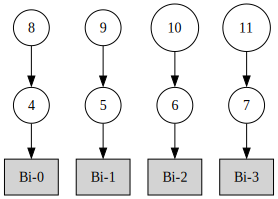

In [3]:
two_armed_bandit_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[5], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[6], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[7], tonic_volatility=-1.0)
    .init()
)
two_armed_bandit_hgf.plot_network()

## Task structure
We start with a simple task structure where contingencies (i.e. the probability that a given armed bandit is associated with a win/loss) alternate between `0.2`, `0.5` and `0.8`. The rate of change in contingencies can be fast (i.e. high volatility blocks) or slow (i.e. low volatility blocks).

In [4]:
# three levels of probability
high_prob, chance, low_prob = 0.8, 0.5, 0.2

# create blocks of contingencies
stable_contingencies = np.array([low_prob, high_prob]).repeat(20)
volatile_contingencies = np.tile(np.array([low_prob, high_prob]).repeat(10), 3)
chance_contingencies = np.array(chance).repeat(40)

In [5]:
# create sequences of blocks for the different cases
win_arm1 = np.concatenate([stable_contingencies, chance_contingencies, volatile_contingencies])
loss_arm1 = np.concatenate([volatile_contingencies, chance_contingencies, stable_contingencies])
win_arm2 = np.concatenate([chance_contingencies, stable_contingencies, volatile_contingencies])
loss_arm2 = np.concatenate([chance_contingencies, volatile_contingencies, stable_contingencies])

In [6]:
# sample trial level outcomes from the sequences
u_win_arm1 = np.random.binomial(n=1, p=win_arm1)
u_loss_arm1 = np.random.binomial(n=1, p=loss_arm1)
u_win_arm2 = np.random.binomial(n=1, p=win_arm2)
u_loss_arm2 = np.random.binomial(n=1, p=loss_arm2)

This gives the following task structure:

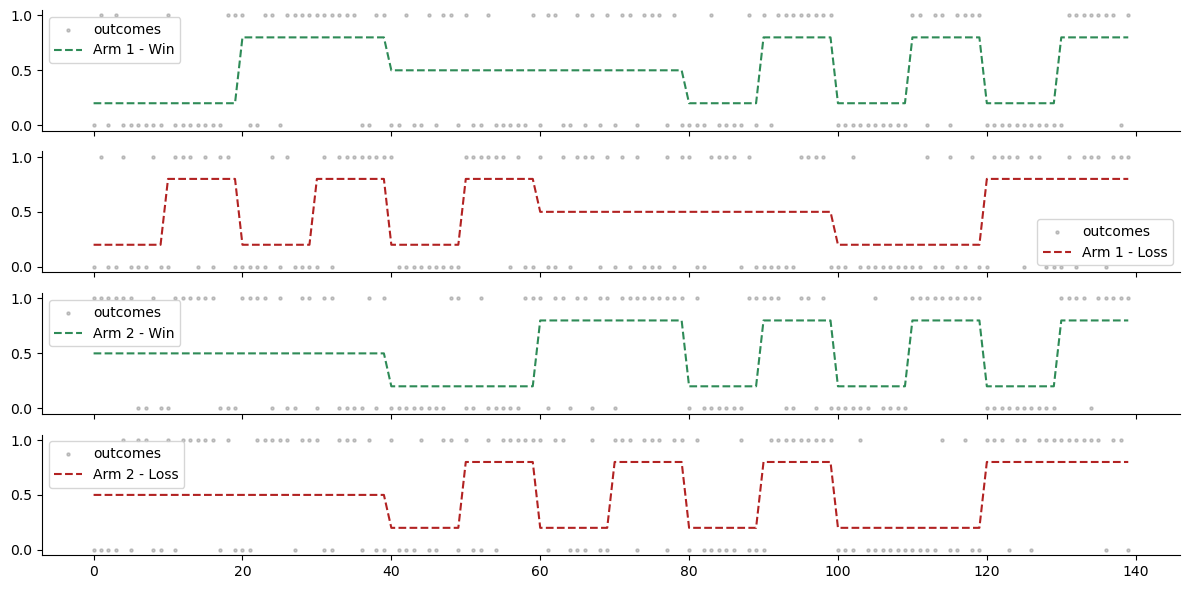

In [7]:
# trial numbers
trials = np.arange(len(win_arm1))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True)

for i, u, p, label, color in zip(
    range(4),
    [u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2], 
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].scatter(trials, u, label="outcomes", alpha=.4, s=5, color="gray")
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()
plt.tight_layout()
sns.despine();

## Simulate a dataset

We can simlate our vector of observation. This is a two dimentional matrix with input observations for the four components of our model.

In [8]:
u = np.array([u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2])

From there, it is straightforward to feed these observations to our four branches HGF to retrieve the trajectories.

```{note}
Here, we are providing all the outcomes from all trials. This is not how the task would work as the participant will only be presented with the outcomes from the armed bandit chosen, and we are not using responses from the participant yet. See also {ref}`custom_response_functions` for details on the observations `u` and the responses `y`.
```

In [9]:
two_armed_bandit_hgf.input_data(input_data=u.T);

Adding 140 new observations.


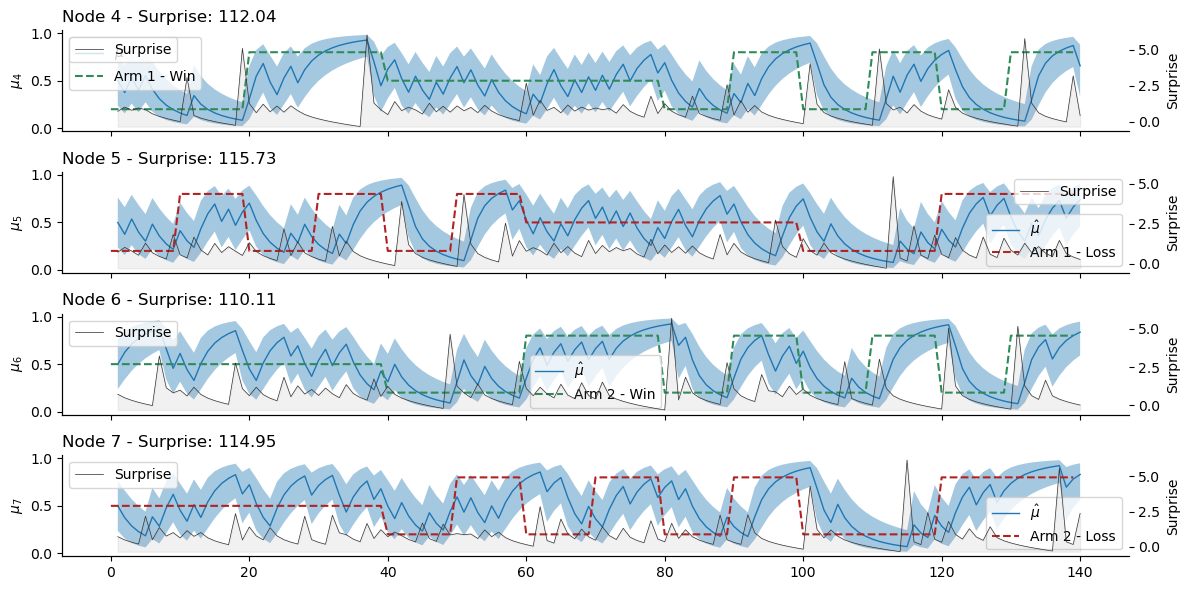

In [10]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()

plt.tight_layout()
sns.despine();

## Simulate responses from a participant
Using the beliefs trajectories recovered from the model fits above, we can simulate responses from a participant that would use the same parametrisation of beliefs update (especially the same `tonic_volatility` here).

### Decision rule

The probability of chosing the arm $A$ given the probability of wining on both arms ${W_a; W_b}$ and the probability of loosing on both arms ${L_a; L_b}$, is given by the following softmax decision function:

$$
p(A) = \frac{e^{\beta(W_a-L_a)}}{e^{\beta(W_a-L_a)} + e^{\beta(W_b-L_b)}}
$$

where $\beta$ is the inverse temperature parameter.

In [11]:
beta = 1.0
w_a = two_armed_bandit_hgf.node_trajectories[4]["expected_mean"]
l_a = two_armed_bandit_hgf.node_trajectories[5]["expected_mean"]
w_b = two_armed_bandit_hgf.node_trajectories[6]["expected_mean"]
l_b = two_armed_bandit_hgf.node_trajectories[7]["expected_mean"]

p_a = np.exp(beta * (w_a-l_a)) / ( np.exp(beta * (w_a-l_a)) + np.exp(beta * (w_b-l_b)))

Using these probabilities, we can infer which arm was selected at each trial and filter the inputs that are presented to the participant. Because it would be too chaotic to provide the information about the four hidden states at each trial, here the participant is only presented with the information about the arm that was selected. Therefore, when arm $A$ is selected, the inputs from arm $B$ are set to `jnp.nan` and will be ignored during the node update.

In [12]:
# filter the input sequence using the agent's decisions
missing_inputs_u = u.astype(float)
missing_inputs_u[:2, p_a<=.5] = np.nan
missing_inputs_u[2:, p_a>.5] = np.nan

```{note}
Missing inputs are used to indicate an absence of observation from the agent's point of view and should not be used for missing records or excluded trials. When an input is labelled as missing, we use the total volatility at the parents' level to decrease their precision as a function of time elapsed, but the means are still the same. Because this functionality implies an overhead of checks, it is deactivated by default. To activate it, we need to set `allow_missing_iputs` to `True` upon model creation.
```

Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


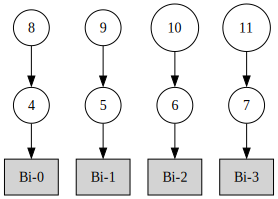

In [13]:
two_armed_bandit_missing_inputs_hgf = (
    HGF(model_type=None, allow_missing_inputs=True)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=-2.0)
    .add_value_parent(children_idxs=[5], tonic_volatility=-2.0)
    .add_value_parent(children_idxs=[6], tonic_volatility=-2.0)
    .add_value_parent(children_idxs=[7], tonic_volatility=-2.0)
    .init()
)
two_armed_bandit_hgf.plot_network()

In [14]:
two_armed_bandit_missing_inputs_hgf.input_data(input_data=missing_inputs_u.T);

Adding 140 new observations.


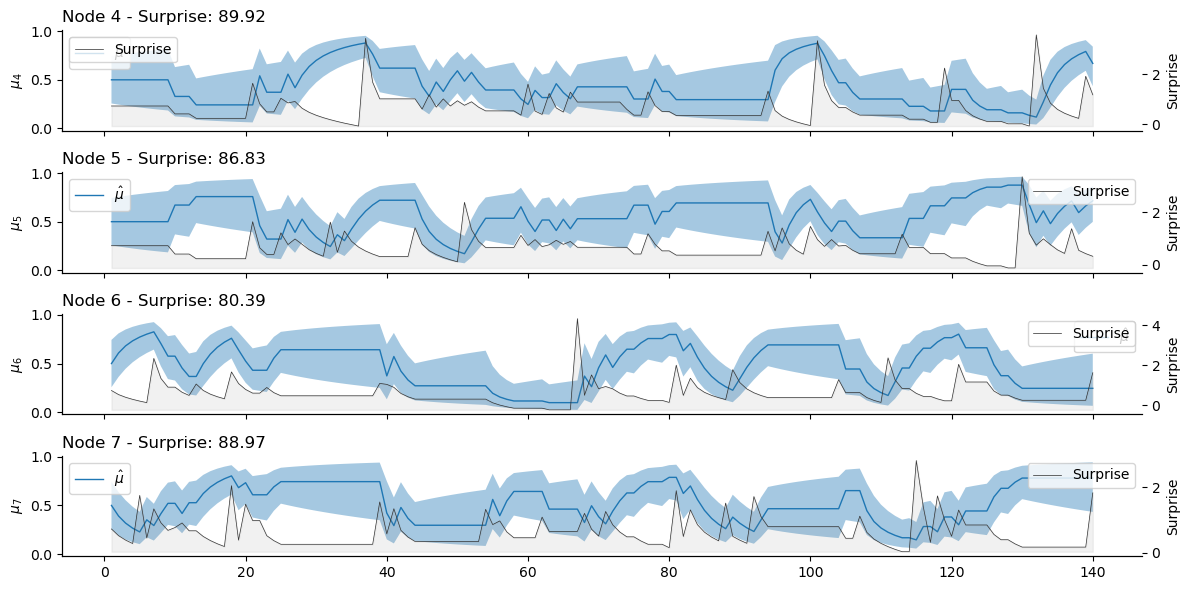

In [15]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=7, axs=axs[3])

plt.tight_layout()
sns.despine();

We can now see from the plot above that the branches of the networks are now only updated if the participant actually chose the corresponding arm. Otherwise the expected probability remains the same but the uncertainty will increase over time.

## Parameter recovery

Now that we have set a model with the required number of branches, and allowed this model to observe missing inputs, we can simulate responses from a participant and try to recover the parameters. It should be noted here that this kind of model implies that the decisions of the agent directly influence the observations, as only the outcomes from the selected armed bandit are presented to the participant. This implies that - for simulations - we cannot iterate over the whole set of observations before estimating the decision function, and should every step sequentially in a for loop. This is an important difference as most of the models discussed in the other tutorials filter all the observations first, and then compute the response costs, as the two processes are not influencing each other.

### Real-time decision and belief updating

We can implement this process using the {py:func}`pyhgf.networks.beliefs_propagation` function. In other models, this step is called sequentially in a {py:func}`jax.lax.scan` loop, but we can also use it for a single-step update.

In [16]:
from pyhgf.networks import beliefs_propagation

In [17]:
tv = -3.0

two_armed_bandit_missing_inputs_hgf = (
    HGF(model_type=None, allow_missing_inputs=True, verbose=False)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=tv)
    .add_value_parent(children_idxs=[5], tonic_volatility=tv)
    .add_value_parent(children_idxs=[6], tonic_volatility=tv)
    .add_value_parent(children_idxs=[7], tonic_volatility=tv)
    .init()
)

In [18]:
# add a time step vector
input_data = np.c_[u.T, np.ones(u.shape[1])]

# get the network variables from the HGF class
attributes = two_armed_bandit_missing_inputs_hgf.attributes
update_sequence = two_armed_bandit_missing_inputs_hgf.update_sequence
edges = two_armed_bandit_missing_inputs_hgf.edges
input_nodes_idx = two_armed_bandit_missing_inputs_hgf.input_nodes_idx.idx

# temperature parameter for decision softmax
beta = 1.0

In [19]:
responses = []  # 1: arm A - 0: arm B
for i in range(input_data.shape[0]):

    # expectations about the outcomes
    w_a = attributes[4]["expected_mean"]
    l_a = attributes[5]["expected_mean"]
    w_b = attributes[6]["expected_mean"]
    l_b = attributes[7]["expected_mean"]

    # decision function
    p_a = np.exp(beta * (w_a-l_a)) / ( np.exp(beta * (w_a-l_a)) + np.exp(beta * (w_b-l_b)))

    # hide the observations that were not selected
    if p_a > .5:
        input_data[i, :2] = np.nan
        responses.append(1)
    else:
        input_data[i, 2:4] = np.nan
        responses.append(0)
    
    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        data=input_data[i],
        update_sequence=update_sequence,
        edges=edges,
        input_nodes_idx=input_nodes_idx
    )
responses = jnp.asarray(responses)

### Bayesian inference

First, we start by creating the response function we want to optimize (see also {ref}`custom_response_functions` on how to create such functions).

In [20]:
from pyhgf.math import binary_surprise
from jax.tree_util import Partial
from jax import jit
from pytensor.graph import Apply, Op
import pytensor.tensor as pt
from jax import grad, jit, vjp

def two_bandits_logp(tonic_volatility, hgf, input_data, responses):

    # replace with a new omega in the model
    hgf.attributes[8]["tonic_volatility"] = tonic_volatility
    hgf.attributes[9]["tonic_volatility"] = tonic_volatility
    hgf.attributes[10]["tonic_volatility"] = tonic_volatility
    hgf.attributes[11]["tonic_volatility"] = tonic_volatility

    # run the model forward
    hgf.input_data(input_data=input_data)

    # probabilities of choosing arm A
    beta = 1.0
    w_a = hgf.node_trajectories[4]["expected_mean"]
    l_a = hgf.node_trajectories[5]["expected_mean"]
    w_b = hgf.node_trajectories[6]["expected_mean"]
    l_b = hgf.node_trajectories[7]["expected_mean"]
    p_a = jnp.exp(beta * (w_a-l_a)) / ( jnp.exp(beta * (w_a-l_a)) + jnp.exp(beta * (w_b-l_b)))

    # binary surprise given this probability
    surprise = jnp.sum(binary_surprise(responses, p_a))

    # the surprise of the model is the sum of binary surprise at all input level
    # plus the binary surprise for the agent decision 
    surprise_1 = jnp.sum(binary_surprise(
        x=input_data[:, 0],
        expected_mean=hgf.node_trajectories[4]["expected_mean"]
    ))
    surprise_2 = jnp.sum(binary_surprise(
        x=input_data[:, 1],
        expected_mean=hgf.node_trajectories[5]["expected_mean"]
    ))
    surprise_3 = jnp.sum(binary_surprise(
        x=input_data[:, 2],
        expected_mean=hgf.node_trajectories[6]["expected_mean"]
    ))
    surprise_4 = jnp.sum(binary_surprise(
        x=input_data[:, 3],
        expected_mean=hgf.node_trajectories[7]["expected_mean"]
    ))

    surprise = surprise_1 + surprise_2 + surprise_3 + surprise_4 + surprise

    surprise = jnp.where(
        jnp.isnan(surprise),
        jnp.inf,
        surprise
    )
    return -surprise

In [21]:
logp_fn = Partial(
    two_bandits_logp, 
    hgf=two_armed_bandit_missing_inputs_hgf, 
    input_data=input_data[:, :-1],
    responses=responses
)

We create both jitted and the vector-jacobian product requiered for a custom Op in PyTensor:

In [22]:
jitted_custom_op_jax = jit(logp_fn)

def vjp_custom_op_jax(x, gz):
    _, vjp_fn = vjp(logp_fn, x)
    return vjp_fn(gz)[0]

jitted_vjp_custom_op_jax = jit(vjp_custom_op_jax)

In [23]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, x):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [pt.as_tensor_variable(x)]
        # Output has the same type and shape as `x`
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (x,) = inputs
        result = jitted_custom_op_jax(x)
        # The results should be assigned in place to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        (x,) = inputs
        (gz,) = output_gradients
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [vjp_custom_op(x, gz)]


class VJPCustomOp(Op):
    def make_node(self, x, gz):
        # Make sure the two inputs are tensor variables
        inputs = [pt.as_tensor_variable(x), pt.as_tensor_variable(gz)]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, gz) = inputs
        result = jitted_vjp_custom_op_jax(x, gz)
        outputs[0][0] = np.asarray(result, dtype="float64")

# Instantiate the Ops
custom_op = CustomOp()
vjp_custom_op = VJPCustomOp()

In [24]:
with pm.Model() as model:
    tonic_volatility = pm.Normal("tonic_volatility", -2.0, 2)
    pm.Potential("hgf", custom_op(tonic_volatility))
    idata = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tonic_volatility]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


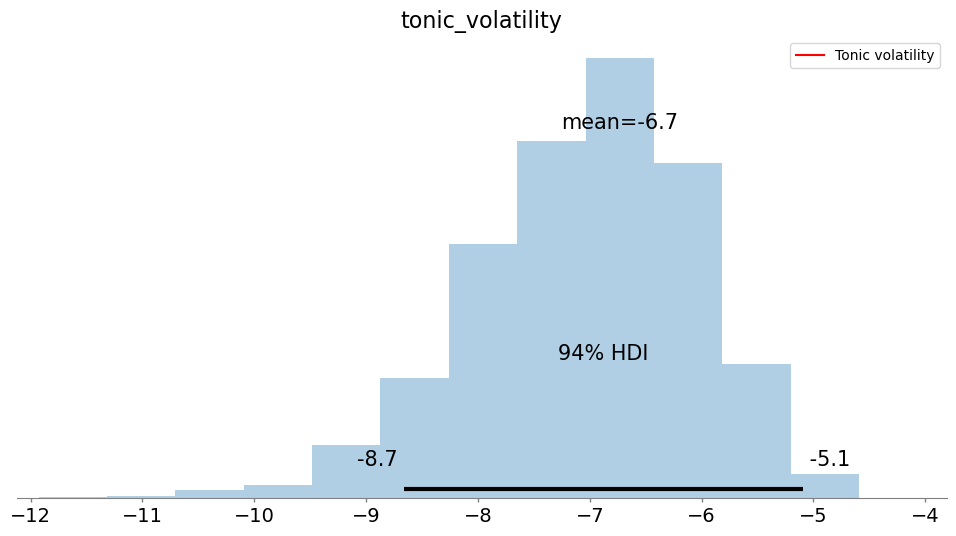

In [25]:
_, ax = plt.subplots(figsize=(12, 6))
az.plot_posterior(idata, ax=ax, kind='hist')
ax.axvline(tv, color="r", label="Tonic volatility")
plt.legend();

## System configuration

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Wed Nov 22 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.12
jax   : 0.4.16
jaxlib: 0.4.16

numpy     : 1.22.0
pytensor  : 2.17.3
seaborn   : 0.12.2
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
arviz     : 0.16.1
jax       : 0.4.16
pymc      : 5.9.1
matplotlib: 3.7.1

Watermark: 2.4.3

